In [14]:
!pip install -r requirements.txt

In [15]:
# -----------------------------------------------------------
# Dissertation Project: An Empirical Study on the Classification 
# Performance of Deep Learning vs. Gradient Boosting 
# on heterogeneous tabular data
#
# This module provides functions for running and analyzing results from the NODE,
# model. It includes methods for model training, 
# performance evaluation, and interpretation of results.
#
# Author: Adam Mabrouk
# Supervisor: Ben Ralph
# Institution: University of Bath
# Created on: 01/01/2024
# Version: 1.0
#
# Acknowledgments:
# The NODE architecture in this code has been adapted from the Authors: 
# Popov, S., Morozov, S. and Babenko, A., 2019. Neural oblivious decision ensembles for deep learning on tabular data. 
# arXiv preprint arXiv:1909.06312. Source paper: https://arxiv.org/pdf/1909.06312v2.pdf
# Adapted NODE architecture: Author: Sergey Popov, Source: https://github.com/Qwicen/node/blob/master/lib/odst.py
# Adapted Model training: Author: https://github.com/anonICLR2020/node/blob/master/lib/trainer.py  
# -----------------------------------------------------------

# Library Versions Used
# ----------------------
# Python version: 3.11.5 


# Standard library imports for model training time and warnings.
from time import time
import numpy as np
import warnings

# Specific python file imports to run the model
from node_model import create_node, optuna_node_params
from model_training import ModelTraining
from Results import ModelResults
from data_loader import load_data

# Miscellaneous settings
warnings.filterwarnings('ignore')

In [16]:
random_seed = np.random.randint(1,1000)
random_seed

211

- **Operating this notebook**

    - `Select dataset (Currently set to 5k)`
    - `Copy and past parameters from manual or optuna below`
    - `Select optuna to True to run or False to use manual (Currently set to True)`
    - `Uncomment to record results below (Currently set to not save results) If saved they are saved directly in the model_results_for_further_testing folder`

In [3]:
root_path = "."
data_source = "datasets"

"""Select dataset"""

data = 'lending_club_dataset'
# data = 'heloc_dataset'
# data = 'adult_income_dataset'
folder_name = data
subset_size = 5000 # put number 10k,

X_train, y_train, X_val, y_val, X_test, y_test = load_data(root_path, data_source, folder_name, subset_size)

In [4]:
use_optuna = True # True or False
checkpoint_name = "Node"
log_dir = f"logs/Node/{time()}"
create_model_function = create_node

seed = 42
epochs = 30 # 30
verbose = 1
n_trials = 20 # 20

best_params = {
    
    "batch_size": 32, 
    "soft_tree_layer": 3, # 1=ablation
    "dropout_rate": 0.3,
    "depth_of_tree": 3, # 1=ablation
    "soft_trees": 1, # 5=ablation
    "seed": random_seed, 
    "learning_rate": 0.0023, # 0.1=ablation FOR TIMED RUNS, SAME LEARNING RATE AND BATCH SIZE 32
    "lr_reduce_factor": 0.16, # 0.3=ablation  
    "lr_reduce_patience": 9, 
    "lr_reduce_threshold": 0.002}

params = optuna_node_params if use_optuna else best_params

model_training = ModelTraining(random_seed, 
                               use_optuna, checkpoint_name, log_dir, create_model_function,
                     epochs, verbose, n_trials, params)

model, history, final_training_time = model_training.train_and_evaluate(X_train, y_train, X_val, y_val)


Best params: {'batch_size': 32, 'soft_tree_layer': 3, 'dropout_rate': 0.3, 'depth_of_tree': 3, 'soft_trees': 1, 'seed': 128, 'learning_rate': 0.0023, 'lr_reduce_factor': 0.16, 'lr_reduce_patience': 9, 'lr_reduce_threshold': 0.002}
Epoch 1/30
125/125 [==============================] - 4s 6ms/step - loss: 0.7816 - auprc: 0.5057 - val_loss: 0.5325 - val_auprc: 0.8161
Epoch 2/30
125/125 [==============================] - 0s 2ms/step - loss: 0.7415 - auprc: 0.5146 - val_loss: 0.5638 - val_auprc: 0.8065
Epoch 3/30
125/125 [==============================] - 0s 3ms/step - loss: 0.7167 - auprc: 0.5107 - val_loss: 0.5950 - val_auprc: 0.8125
Epoch 4/30
125/125 [==============================] - 0s 3ms/step - loss: 0.7024 - auprc: 0.5708 - val_loss: 0.6106 - val_auprc: 0.8466
Epoch 5/30
125/125 [==============================] - 0s 3ms/step - loss: 0.6899 - auprc: 0.6326 - val_loss: 0.6281 - val_auprc: 0.8534
Epoch 6/30
125/125 [==============================] - 0s 3ms/step - loss: 0.6797 - auprc:

In [5]:
def display_optimal_hyperparameters(study, use_optuna, best_params=None):
    if use_optuna and study is not None:
        print("Best Trial ID:", study.best_trial.number)
        print("Best Trial Value (Performance Metric):", study.best_trial.value)
        print("Optimal Hyperparameters:")
        for key, value in study.best_trial.params.items():
            print(f"  {key}: {value}")
    elif not use_optuna and best_params is not None:
        print("Using predefined best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("No hyperparameters available to display.")

display_optimal_hyperparameters(model_training.study, use_optuna, best_params)

Using predefined best parameters:
  batch_size: 32
  soft_tree_layer: 3
  dropout_rate: 0.3
  depth_of_tree: 3
  soft_trees: 1
  seed: 128
  learning_rate: 0.0023
  lr_reduce_factor: 0.16
  lr_reduce_patience: 9
  lr_reduce_threshold: 0.002


In [6]:
model.summary()

Model: "node"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             multiple                  0         
                                                                 
 batch_normalization (Batch  multiple                  72        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 odt (ODT)                   multiple                  116       
                                                                 
 odt_1 (ODT)                 multiple                  119       
                                                                 
 odt_2 (ODT)                 multiple                  122       
                                                              

In [7]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

16/16 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.32      0.54      0.40        91
           1       0.88      0.74      0.81       409

    accuracy                           0.71       500
   macro avg       0.60      0.64      0.60       500
weighted avg       0.78      0.71      0.73       500



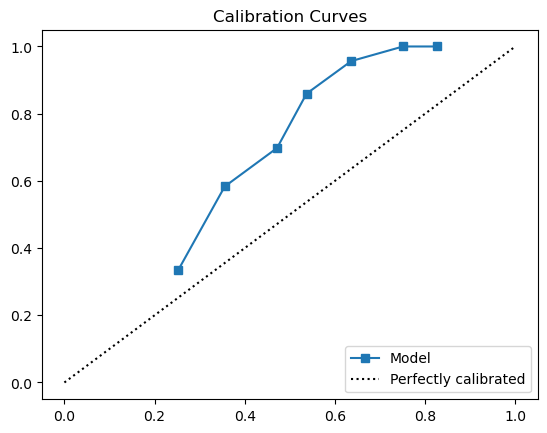

In [8]:
best_model = model

# results = ModelResults(best_model, X_test, y_test, X_train, "NODE", folder_name.replace("_dataset", ""), history, model_training.study)
results = ModelResults(model, X_test, y_test, X_train, None, None, history)

In [ ]:
results.calibration_curve()

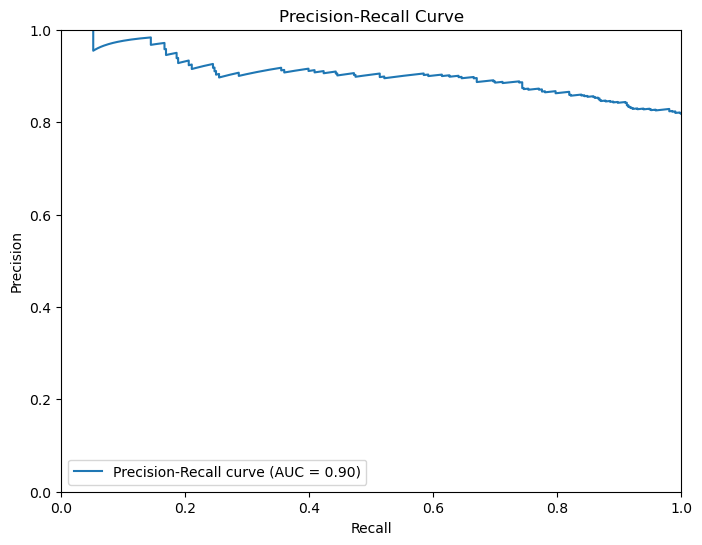

In [9]:
results.auprc()

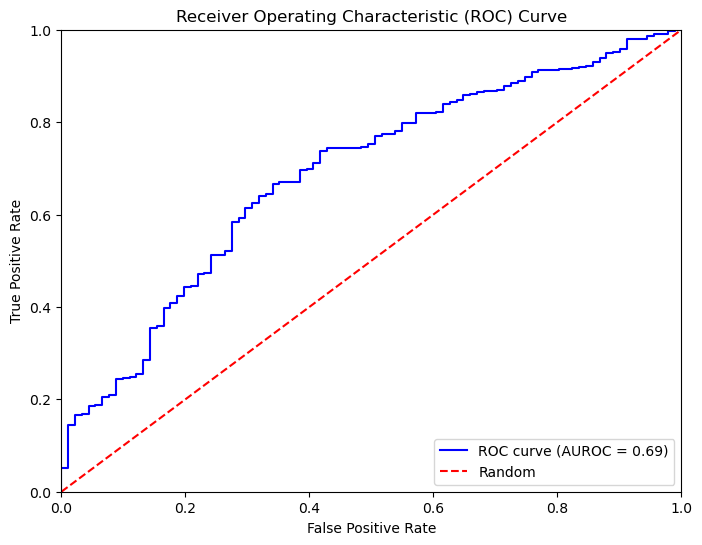

In [10]:
results.auroc()


In [11]:
results.display_metrics()

         Metric Value Percentage
4   Sensitivity  0.74      74.0%
5   Specificity  0.54      54.0%
6      Accuracy  0.71      71.0%
7     Precision  0.88      88.0%
8        Recall  0.74      74.0%
9      F1-score  0.81      81.0%
10       G-Mean  0.63      63.0%


True Negatives:  49
False Positives:  42
False Negatives:  105
True Positives:  304


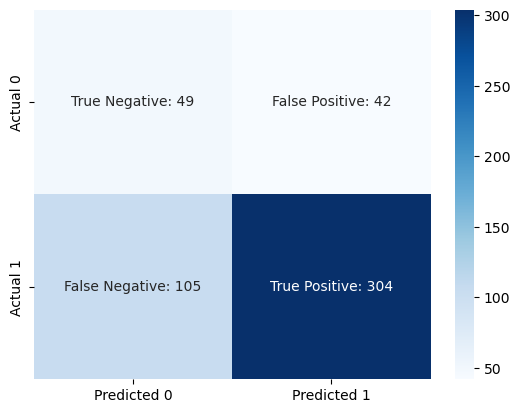

In [12]:
results.confusion_matrix()


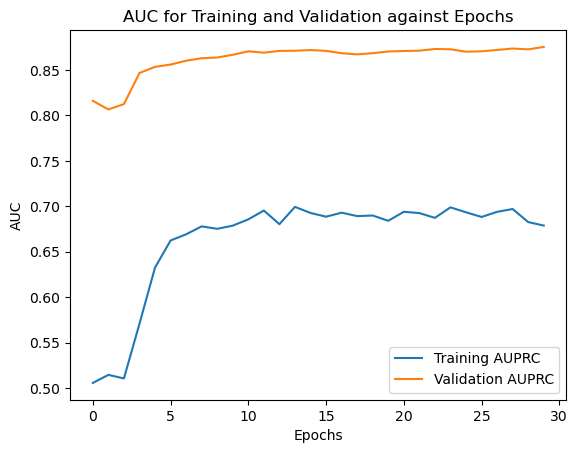

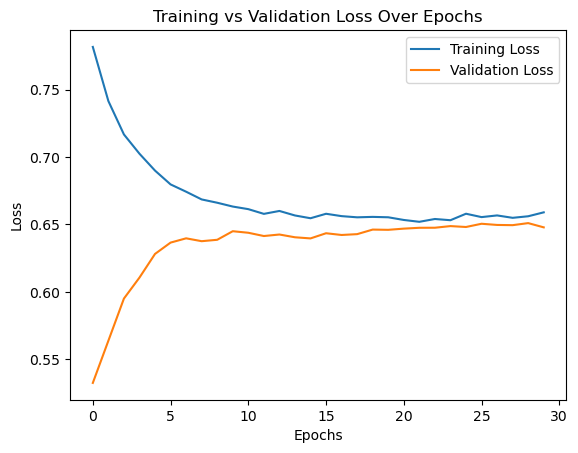

In [13]:
results.model_history()


In [ ]:
inference_time = results.measure_inference_time()

In [ ]:
results.save_time_results_to_csv(final_training_time, inference_time) 

In [ ]:
results.optuna_trials_history()


In [ ]:
results.optuna_hyperparameter_importances()


In [ ]:
results.xai_shap()


In [ ]:
"""Best manual parameters with and without early stopping """
    
# adult income
# best_params = {
    
    # "batch_size": 64, 
    # "soft_tree_layer": 6, # 1=ablation
    # "dropout_rate": 0.2,#0.25,
    # "depth_of_tree": 8, # 1=ablation
    # "soft_trees": 1, # 5=ablation
    # "seed": random_seed, 
    # "learning_rate": 0.0083, # 0.1=ablation
#     "lr_reduce_factor": 0.16, # 0.3=ablation  
#     "lr_reduce_patience": 9, 
#     "lr_reduce_threshold": 0.002}

# lending club
    # "batch_size": 32, 64, 
    # "soft_tree_layer": 3, # 1=ablation
    # "dropout_rate": 0.5, 0.3, 0.25,
    # "depth_of_tree": 3, 8, # 1=ablation
    # "soft_trees": 1, # 5=ablation
    # "seed": random_seed, 
    # "learning_rate": 0.0083, # 0.1=ablation
    # "lr_reduce_factor": 0.16, # 0.3=ablation  
    # "lr_reduce_patience": 9, 
    # "lr_reduce_threshold": 0.002}
    
# Heloc
# best_params = {
    
    # "batch_size": 32, 
    # "soft_tree_layer": 3, # 1=ablation
    # "dropout_rate": 0.3,
    # "depth_of_tree": 3, # 1=ablation
    # "soft_trees": 1, # 5=ablation
    # "seed": random_seed, 
    # "learning_rate": 0.0023, # 0.1=ablation
    # "lr_reduce_factor": 0.16, # 0.3=ablation  
    # "lr_reduce_patience": 9, 
    # "lr_reduce_threshold": 0.002}

In [ ]:
"""Optuna best params with early stopping"""

# optuna lending club 
# Best Trial ID: 15
# Best Trial Value (Performance Metric): 0.8930460214614868
# Optimal Hyperparameters:
  # batch_size: 64
  # soft_tree_layer: 3
  # dropout_rate: 0.40941648844123757
  # depth_of_tree: 3
  # soft_trees: 3
#   seed: 959
#   learning_rate: 0.09301163089173965
#   lr_reduce_factor: 0.15085297051756807
#   lr_reduce_patience: 9
#   lr_reduce_threshold: 0.004180467705276613

#Heloc
# Best Trial ID: 7
# Best Trial Value (Performance Metric): 0.5909047722816467
# Optimal Hyperparameters:
#   soft_tree_layer: 2
#   dropout_rate: 0.381507693224413
#   depth_of_tree: 8
#   soft_trees: 1
#   seed: 934
#   learning_rate: 0.021498484640220944
#   batch_size: 512
#   lr_reduce_factor: 0.1586834796094824
#   lr_reduce_patience: 7
#   lr_reduce_threshold: 0.005747405359509238

# adult income
# Best Trial ID: 11
# Best Trial Value (Performance Metric): 0.6859735250473022
# Optimal Hyperparameters:
#   soft_tree_layer: 5
#   dropout_rate: 0.11354991015005611
#   depth_of_tree: 6
#   soft_trees: 1
#   seed: 684
#   learning_rate: 0.09885592347991586
#   batch_size: 64
#   lr_reduce_factor: 0.10295126551196768
#   lr_reduce_patience: 9
#   lr_reduce_threshold: 0.0001435784473639702